In [ ]:
!pip install matplotlib_venn gensim matpltlib pandas numpy tqdm

In [1]:
from collections import Counter
from functools import reduce
import os


from matplotlib_venn import venn2_unweighted
from gensim.utils import deaccent
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd
import numpy as np

tqdm.pandas()


In [2]:
datasets = dict()

In [3]:
RAW_DATA_DIR = "raw_data"

In [4]:
%cd {RAW_DATA_DIR}

/mnt/d/Pesquisa/Fact br eval/raw_data


## A - Baixar dados

In [ ]:
!wget https://github.com/kamplus/FakeNewsSet/raw/master/Dataset/News_fake.csv
!wget https://github.com/kamplus/FakeNewsSet/raw/master/Dataset/News_notFake.csv
!wget https://zenodo.org/record/5191798/files/central_de_fatos.csv
!wget https://github.com/Gabriel-Lino-Garcia/FakeRecogna/raw/master/dataset/FakeRecogna.xlsx
!git clone https://github.com/roneysco/Fake.br-Corpus
!gdown --id 1Xx_4bw37cgrEkEhQ1toLsIbAj2pLgvDx -O fact-check_tweet_dataset.zip
!unzip fact-check_tweet_dataset.zip

## B - Importar dados

In [5]:
datasets["Central de fatos"] = pd.read_csv("central_de_fatos.csv", sep=";")
print(datasets["Central de fatos"].shape[0])
datasets["Central de fatos"]["rating"] = datasets["Central de fatos"]["rating"].str.lower().apply(eval).apply(set)
datasets["Central de fatos"] = datasets["Central de fatos"][datasets["Central de fatos"]["rating"].apply(len) == 1]
print(datasets["Central de fatos"].shape[0])
datasets["Central de fatos"]["categories"] = datasets["Central de fatos"]["categories"] \
    .apply(lambda c: eval(c) if isinstance(c, str) and "[" in c else c) \
    .apply(lambda c: c[0] if isinstance(c, list) and len(c) > 0 else c) \
    .apply(lambda c: "" if isinstance(c, list) and len(c) == 0 else c)

11647
10551


In [6]:
fake_news_set_fake = pd.read_csv("News_fake.csv")
fake_news_set_fake["alternative_name"] = "fake"

fake_news_set_not_fake = pd.read_csv("News_notFake.csv")
fake_news_set_not_fake["alternative_name"] = "not_fake"

fake_news_set = pd.concat([fake_news_set_fake, fake_news_set_not_fake])
datasets["FakeNewsSet"] = fake_news_set
datasets["FakeNewsSet"]["tweet_ids"] = datasets["FakeNewsSet"]["tweet_ids"].str.split("\t")

In [7]:
print(datasets["FakeNewsSet"].shape[0])
print(datasets["FakeNewsSet"]["tweet_ids"].apply(len).sum())

600
27059


In [8]:
columns = [
 "author",
 "link",
 "category",
 "date of publication",
 "number of tokens",
 "number of words without punctuation",
 "number of types",
 "number of links inside the news",
 "number of words in upper case",
 "number of verbs",
 "number of subjuntive and imperative verbs",
 "number of nouns",
 "number of adjectives",
 "number of adverbs",
 "number of modal verbs (mainly auxiliary verbs)",
 "number of singular first and second personal pronouns",
 "number of plural first personal pronouns",
 "number of pronouns",
 "pausality",
 "number of characters",
 "average sentence length",
 "average word length",
 "percentage of news with speeling errors",
 "emotiveness",
 "diversity",
]

raw_data = list()


for label in ["fake", "true"]:
    text_dir = os.path.join("Fake.br-Corpus", "full_texts", label)
    metadata_dir = os.path.join("Fake.br-Corpus", "full_texts", f"{label}-meta-information")
    crop_dir = os.path.join("Fake.br-Corpus", "size_normalized_texts", label)

    for example in tqdm(os.listdir(text_dir)):
        text_path = os.path.join(text_dir, example)
        metadata_path = os.path.join(metadata_dir, example.replace(".txt","-meta.txt"))
        crop_path = os.path.join(crop_dir, example)
    
        with open(text_path, "r") as f:
            text = f.read()

        cropped_text = np.nan
        if os.path.exists(crop_path):
            with open(crop_path, "r") as f:
                cropped_text = f.read()

        with open(metadata_path, "r") as f:
            metadata = f.read().split("\n")

        example_data =  dict(zip(columns, metadata))
        example_data["text"] = text
        example_data["size_normalized_text"] = cropped_text
        example_data["label"] = label

        raw_data.append(example_data)

raw_data = pd.DataFrame(raw_data)
prepro_data = pd.read_csv(os.path.join("Fake.br-Corpus", "preprocessed", "pre-processed.csv"), index_col="index")
raw_data["preprocessed_news"] = prepro_data["preprocessed_news"]
datasets["Fake.br"] = raw_data

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

In [9]:
datasets["Fact-check_tweet"] = pd.read_csv("pt_pt.csv")
print(datasets["Fact-check_tweet"].shape[0])
datasets["Fact-check_tweet"] = datasets["Fact-check_tweet"][~datasets["Fact-check_tweet"]["article_url"].str.startswith("https://factly.in")]
datasets["Fact-check_tweet"] = datasets["Fact-check_tweet"].reset_index()
print(datasets["Fact-check_tweet"].shape[0])

804
803


In [10]:
datasets["FakeRecogna"] = pd.read_excel("FakeRecogna.xlsx")
print(datasets["FakeRecogna"].shape[0])
datasets["FakeRecogna"] = datasets["FakeRecogna"][datasets["FakeRecogna"]["URL"].notna()]
print(datasets["FakeRecogna"].shape[0])

11903
11902


## C - Selecionar datasets

Selecionei somente os datasets que possuem uma url atrelada a alegação e/ou a fonte

In [11]:
claim_datasets = {
    "Fake.br": 'link',

    # ambos são de tweets
    "Fact-check_tweet": 'tweet_id',
    "FakeNewsSet": "tweet_ids",
}


review_datasets = {
    "FakeRecogna": 'URL',
    "Central de fatos": 'url',
    "Fact-check_tweet": 'article_url',
    "FakeNewsSet": 'news_url',
}

## D - Análises iniciais

In [12]:
treat_url = lambda url: "//".join(url.split("//")[1:]).replace("www.","")

review_urls = {dataset: set(datasets[dataset][review_datasets[dataset]]) for dataset in review_datasets}
review_urls = {d: {treat_url(url) for url in urls} for d, urls in review_urls.items()}

In [13]:
def norm_domain(domain):
    for suffix in ["gazetadigital.com.br", "tnh1.com.br", "folhavitoria.com.br", "jornaldebrasilia.com.br"]:
        if domain in suffix:
            return "r7.com"

    for suffix in ["globo.com", "uol.com.br", "estadao.com.br", "sapo.pt", "afp.com", "r7.com"]:
        if suffix in domain:
            return suffix

    return domain

In [14]:
agency_count = dict()

for dataset in review_urls.keys():
    dataset_agencies = Counter(url.split("/")[0] for url in review_urls[dataset] if isinstance(url, str))
    
    for agency in dataset_agencies:
        if not agency in agency_count:
            agency_count[agency] = dict()

        agency_count[agency][dataset] = dataset_agencies[agency]

agency_count = pd.DataFrame(agency_count).T.fillna(0).astype(int)


domain_count = agency_count.reset_index(names="domain")
domain_count["domain"] = domain_count["domain"].apply(norm_domain)

domain_count = domain_count.groupby("domain").sum()
domain_count = domain_count.loc[(domain_count > 0).sum(axis=1).sort_values(ascending=False).index]
domain_count = domain_count[["FakeRecogna", "Central de fatos", "Fact-check_tweet", "FakeNewsSet"]]

In [15]:
domain_count

,FakeRecogna,Central de fatos,Fact-check_tweet,FakeNewsSet
domain,,,,
globo.com,2366,818,76,279
uol.com.br,4950,1825,175,138
afp.com,495,0,49,10
aosfatos.org,0,1431,100,143
boatos.org,2474,5523,95,0
projetocomprova.com.br,388,361,2,0
apublica.org,0,0,4,11
estadao.com.br,0,593,62,0
e-farsas.com,787,0,0,0


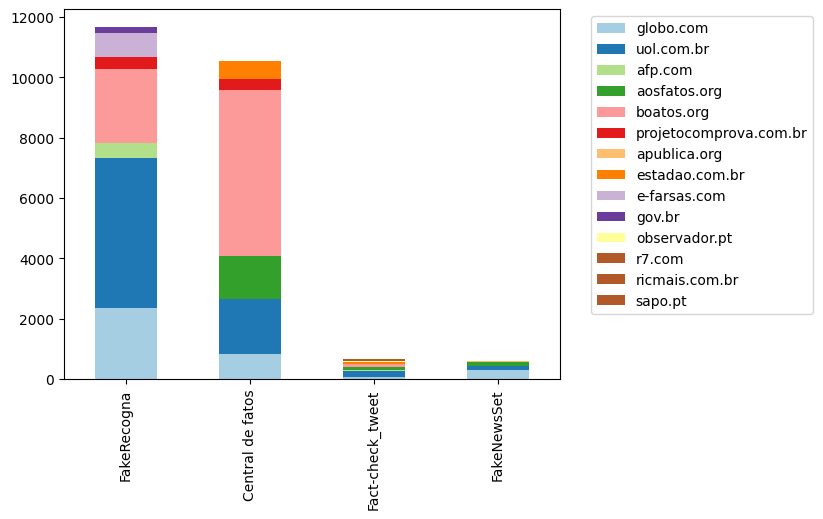

In [16]:
ax = domain_count.T.plot(kind='bar', stacked=True, color=[plt.cm.Paired(i) for i in range(20)])
_ = plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

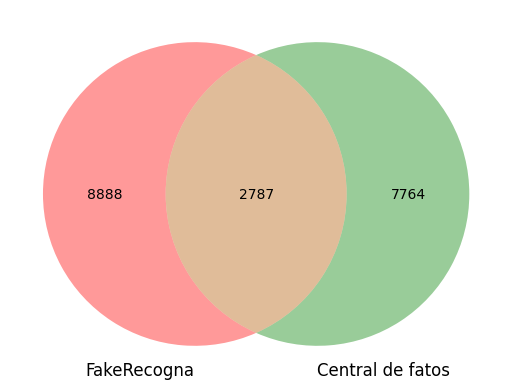

In [17]:
_ = venn2_unweighted([review_urls["FakeRecogna"], review_urls["Central de fatos"]], set_labels=["FakeRecogna", "Central de fatos"])

In [18]:
categories_1  = datasets["FakeRecogna"].value_counts(subset="Categoria").reset_index(name="FakeRecogna")
categories_1["Categoria"] = categories_1["Categoria"].str.lower()

categories_2 = datasets["Central de fatos"]["categories"].value_counts().reset_index().dropna()
categories_2 = categories_2.rename(columns={"index": "Categoria", "categories": "Central de fatos"})
categories_2["Categoria"] = categories_2["Categoria"].str.lower()

In [19]:
categories_2.merge(categories_1)

,Categoria,Central de fatos,FakeRecogna
0,política,1569,3951
1,brasil,1081,904
2,saúde,660,4456
3,mundo,555,580
4,entretenimento,464,1409
5,ciência,79,602


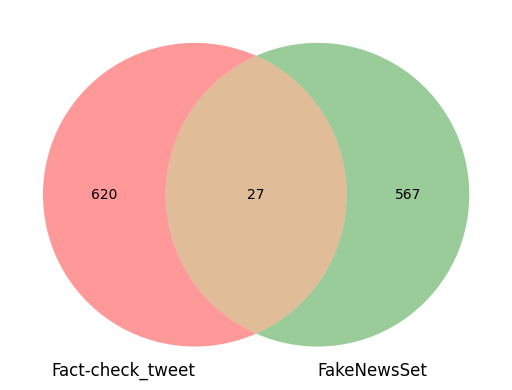

In [20]:
_ = venn2_unweighted([review_urls["Fact-check_tweet"], review_urls["FakeNewsSet"]], set_labels=["Fact-check_tweet", "FakeNewsSet"])

In [21]:
all_review_urls = reduce(lambda a, b: a.union(b), review_urls.values())

review_urls_count = list()
for review_url in all_review_urls:
    item = {"review_url": review_url}
    item.update({dataset: review_url in review_urls[dataset] for dataset in review_urls.keys()})
    review_urls_count.append(item)

review_urls_count = pd.DataFrame(review_urls_count).set_index("review_url")

In [22]:
len(all_review_urls)

20028

In [23]:
domain_count.sum().sum()

23467

In [24]:
review_urls_count.value_counts().reset_index().loc[[0,1,6,3]]

,FakeRecogna,Central de fatos,Fact-check_tweet,FakeNewsSet,0
0,True,False,False,False,8841
1,False,True,False,False,7298
6,False,True,True,False,192
3,False,False,False,True,312


In [25]:
review_urls_count.value_counts().reset_index().loc[[2,8,10,5,4,11]]

,FakeRecogna,Central de fatos,Fact-check_tweet,FakeNewsSet,0
2,True,True,False,False,2675
8,True,False,True,False,42
10,True,False,False,True,5
5,False,True,False,True,250
4,False,False,True,False,274
11,False,False,True,True,3


In [26]:
review_urls_count.value_counts().reset_index().loc[[7,9]]

,FakeRecogna,Central de fatos,Fact-check_tweet,FakeNewsSet,0
7,True,True,True,False,112
9,False,True,True,True,24


In [27]:
review_count = review_urls_count.sum(axis=1).sort_values(ascending=False).reset_index()

In [28]:
review_count[0].value_counts()

1    16725
2     3167
3      136
Name: 0, dtype: int64

In [29]:
tweet_ids = dict()
tweet_ids["Fact-check_tweet"] = set(datasets["Fact-check_tweet"]['tweet_id'])
tweet_ids["FakeNewsSet"] = reduce(lambda a, b: set(a).union(set(b)),datasets["FakeNewsSet"]['tweet_ids'])

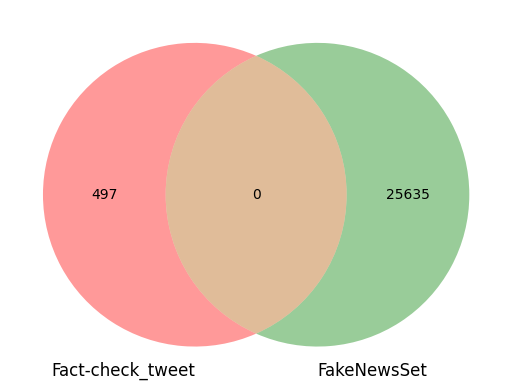

In [30]:
_ = venn2_unweighted([tweet_ids["Fact-check_tweet"], tweet_ids["FakeNewsSet"]], set_labels=["Fact-check_tweet", "FakeNewsSet"])

In [31]:
categories_1_fixed = datasets["FakeRecogna"]["URL"].apply(lambda url: "//".join(url.split("//")[1:]).replace("www.","").split("/")[1])
categories_1_fixed = categories_1_fixed[categories_1_fixed.str.len() < 30].dropna().value_counts().reset_index(name="FakeRecogna").rename(columns={"index": "Categoria"})
categories_2["Categoria"] = categories_2["Categoria"].apply(deaccent)

In [32]:
categories_2.merge(categories_1_fixed,on="Categoria")

,Categoria,Central de fatos,FakeRecogna
0,,2418,503
1,politica,1569,1549
2,brasil,1081,341
3,saude,660,1312
4,mundo,555,395
5,tecnologia,549,295
6,entretenimento,464,167
7,religiao,271,101
8,esporte,215,276
9,ciencia,79,39


## E - Unificar

In [33]:
find_domain = lambda url: norm_domain(treat_url(url).split("/")[0])

In [34]:
url_idx = pd.DataFrame(review_urls_count.index).reset_index()
url_idx["index"] = url_idx["index"].apply(lambda idx: f"review_{idx:05d}")
url_idx = url_idx.set_index("review_url")["index"].to_dict()

In [35]:
raw_df = datasets["FakeRecogna"]

fakeRecogna = pd.DataFrame()

fakeRecogna["review_text"] = raw_df["Titulo"] + "\n" + raw_df["Subtitulo"].fillna("") + "\n" + raw_df["Noticia"]
fakeRecogna["review_text"] = fakeRecogna["review_text"].str.strip()

fakeRecogna["review_author"] = raw_df["Autor"].fillna("").str.strip()
fakeRecogna["review_author"] = fakeRecogna["review_author"].apply(lambda a: a if "/20" not in a else "")
fakeRecogna["review_author"] = fakeRecogna["review_author"].fillna("").str.replace("Por ", "")
fakeRecogna["review_author"] = fakeRecogna["review_author"].apply(lambda a: a if len(a.split(" ")) <= 22 else "")

fakeRecogna["review_url"] = raw_df["URL"].fillna("").str.strip()
fakeRecogna["review_domain"] = fakeRecogna["review_url"].apply(find_domain)

fakeRecogna["review_date"] = raw_df["Data"].fillna("").str.strip()
fakeRecogna["review_date"] = fakeRecogna["review_date"].apply(lambda d: d if isinstance(d, str) and len(d) >= 10 else "")
fakeRecogna["review_date"] = fakeRecogna["review_date"].apply(lambda d: d[:10] if isinstance(d, str) and len(d) > 10 else d)
fakeRecogna["review_date"] = fakeRecogna["review_date"].fillna("").str.strip()

fakeRecogna["category"] = raw_df["Categoria"]
fakeRecogna["is_fake"] = raw_df["Classe"].map({0.0: 1, 1.0: -1})

review_id = fakeRecogna["review_url"].apply(lambda url: "//".join(url.split("//")[1:]).replace("www.","")).map(url_idx)
fakeRecogna.insert(0, "review_id", review_id)

In [36]:
FAKE_LABELS = {"boato", "falso", "fake", "enganoso", "fora de contexto", "distorcido", "exagerado", "constraditório", "impreciso", "insustentável", "contexto errado"}

def map_rating(rating: set):
    if rating.intersection(FAKE_LABELS):
        return 1
    elif rating.intersection({"verdadeiro, mas", "ainda é cedo para dizer"}):
        return 0
    
    return -1

raw_df = datasets['Central de fatos']


central_de_fatos = pd.DataFrame()

central_de_fatos["review_text"] = raw_df["title"] + "\n" + raw_df["subtitle"].fillna("") + "\n" + raw_df["text_news"]
central_de_fatos["review_text"] = central_de_fatos["review_text"].str.strip()

central_de_fatos["review_author"] = ""
central_de_fatos["review_url"] = raw_df["url"].str.strip()
central_de_fatos["review_domain"] = central_de_fatos["review_url"].apply(find_domain)
central_de_fatos["review_date"] = raw_df["publication_date"].fillna("").str.strip()
central_de_fatos["category"] = raw_df["categories"].str.lower()
central_de_fatos["is_fake"] = raw_df["rating"].map(map_rating)

review_id = central_de_fatos["review_url"].apply(lambda url: "//".join(url.split("//")[1:]).replace("www.","")).map(url_idx)
central_de_fatos.insert(0, "review_id", review_id)

In [37]:
fact_check_tt_pt = pd.DataFrame()
raw_df = datasets['Fact-check_tweet']
fact_check_tt_pt["review_url"] = raw_df["article_url"]
fact_check_tt_pt["claim_ids"] = raw_df["tweet_id"].apply(lambda x: [x])
fact_check_tt_pt["is_fake"] = raw_df["label"].map({0: -1, 1:1})
review_id = fact_check_tt_pt["review_url"].apply(lambda url: "//".join(url.split("//")[1:]).replace("www.","")).map(url_idx)
fact_check_tt_pt.insert(0, "review_id", review_id)

In [38]:
fakeNewsSet = pd.DataFrame()
raw_df = datasets["FakeNewsSet"]
fakeNewsSet["review_url"] = raw_df["news_url"]
fakeNewsSet["claim_ids"] = raw_df["tweet_ids"]
fakeNewsSet["is_fake"] = raw_df["alternative_name"].map({"fake": 1, "not_fake":-1})
review_id = fakeNewsSet["review_url"].apply(lambda url: "//".join(url.split("//")[1:]).replace("www.","")).map(url_idx)
fakeNewsSet.insert(0, "review_id", review_id)

In [39]:
fakebr = pd.DataFrame()
raw_df = datasets['Fake.br']
fakebr["claim_text"] = raw_df["text"]
fakebr["claim_author"] = raw_df["author"]
fakebr["claim_url"] = raw_df["link"]
fakebr["claim_date"] = raw_df["date of publication"]
fakebr["category"] = raw_df["category"]
fakebr["is_fake"] = raw_df["label"].map({"fake":  1, "true": -1})

In [40]:
final_dataset = {
    "fact_check_tweet_pt": fact_check_tt_pt,
    "FakeNewsSet": fakeNewsSet,
    "FakeRecogna": fakeRecogna,
    "central_de_fatos": central_de_fatos,
    "fake_br": fakebr,
}

In [41]:
review_urls_count.columns = ["FakeRecogna", "central_de_fatos", "fact_check_tweet_pt", 'FakeNewsSet']

In [42]:
diff_reviews = set()

intersection_urls = review_urls_count[review_urls_count.sum(axis=1) > 1]
for url, row in tqdm(intersection_urls.iterrows(), total=intersection_urls.shape[0]):
    intersection_label = set()

    review_id = url_idx[url]
    for dataset in row[row == True].index:
        dataset_label = final_dataset[dataset][final_dataset[dataset]["review_id"] == review_id]["is_fake"].iloc[0]
        intersection_label.add(dataset_label)

    if len(intersection_label) > 1:
        diff_reviews.add(review_id)
    

  0%|          | 0/3303 [00:00<?, ?it/s]

In [43]:
print(intersection_urls.shape[0], len(diff_reviews))

3303 240


In [44]:
for dataset in final_dataset:
    if not "review_id" in final_dataset[dataset].columns:
        continue

    final_dataset[dataset] = final_dataset[dataset][~final_dataset[dataset]["review_id"].isin(diff_reviews)]

In [45]:
%cd ..

/mnt/d/Pesquisa/Fact br eval


In [46]:
os.makedirs("data")

FileExistsError: [Errno 17] File exists: 'data'

In [49]:
for dataset in final_dataset:
    final_dataset[dataset].to_csv(os.path.join("data",f"{dataset}.tsv"), sep="\t", index=None)

In [52]:
!zip FactChecksbr.zip -r data

updating: data/ (stored 0%)
updating: data/central_de_fatos.tsv (deflated 68%)
updating: data/fact_check_tweet_pt.tsv (deflated 72%)
updating: data/FakeNewsSet.tsv (deflated 61%)
updating: data/FakeRecogna.tsv (deflated 65%)
updating: data/fake_br.tsv (deflated 63%)
